Analysis being conducted on Male participants only. They will further by divided by ethnicity. Because we are looking at differences in responses to the Autism Screening questionnaire this analysis will only use _Score variables as predictors. 

In [ ]:
# Import libraries
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

!pip install mord
from mord import LogisticIT

!pip install scikit-plot
import scikitplot as skplt
!pip install dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary, liftChart, gainsChart, adjusted_r2_score, backward_elimination, forward_selection, AIC_score, BIC_score
from dmba.metric import AIC_score

import heapq
from collections import defaultdict
from mlxtend.frequent_patterns import apriori, association_rules
!pip install surprise
from surprise import Dataset, Reader, KNNBasic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
no display found. Using non-interactive Agg backend
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Upload autism dataset
autism_df = pd.read_csv('autism_df.csv')
autism_df.shape

(703, 21)

In [ ]:
# Create new dataset from autism_df for male-only records
male_df = autism_df[(autism_df['gender']=='m')]
male_df.shape

(367, 21)

In [ ]:
# Split the dataset with Class/ASD as the target variable. 
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= male_df[predictors]
y= male_df[outcome]
# Transform categorical varialbes to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Create a maximal tree
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check model accuracy
classificationSummary(train_Y, fullClassTree.predict(train_X))
classificationSummary(valid_Y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 168   0
     1   0  52
Confusion Matrix (Accuracy 0.9184)

       Prediction
Actual   0   1
     0 107   6
     1   6  28


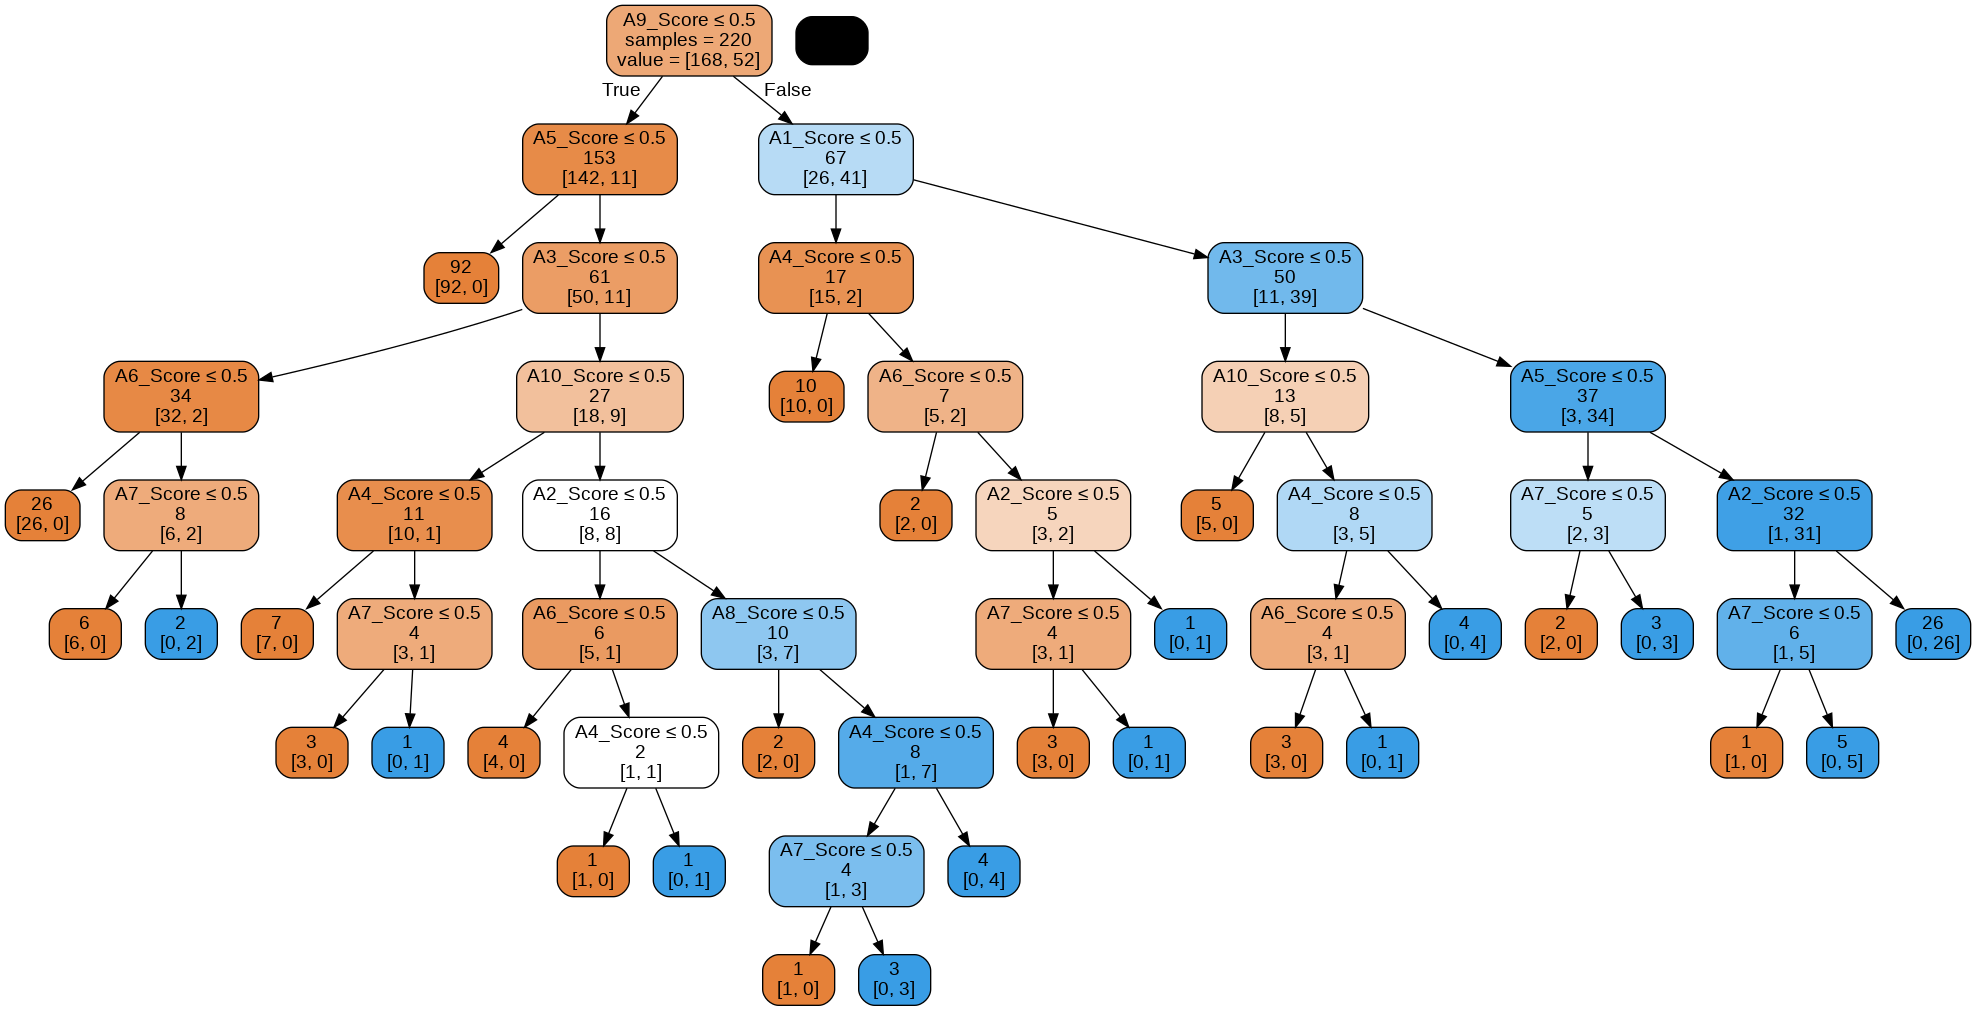

In [ ]:
# Plot the tree
plotDecisionTree(fullClassTree, feature_names=train_X.columns)

NOTE: Several permuations of parameters were considered when conducting gridsearches

In [ ]:
# Create parameters to optimize the tree.
param_grid = {
    'max_depth':[3, 5, 6, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [ ]:
# Run a grid search to find the best parameters.
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 6, 'min_impurity_decrease': 0.001, 'min_samples_split': 0.01}

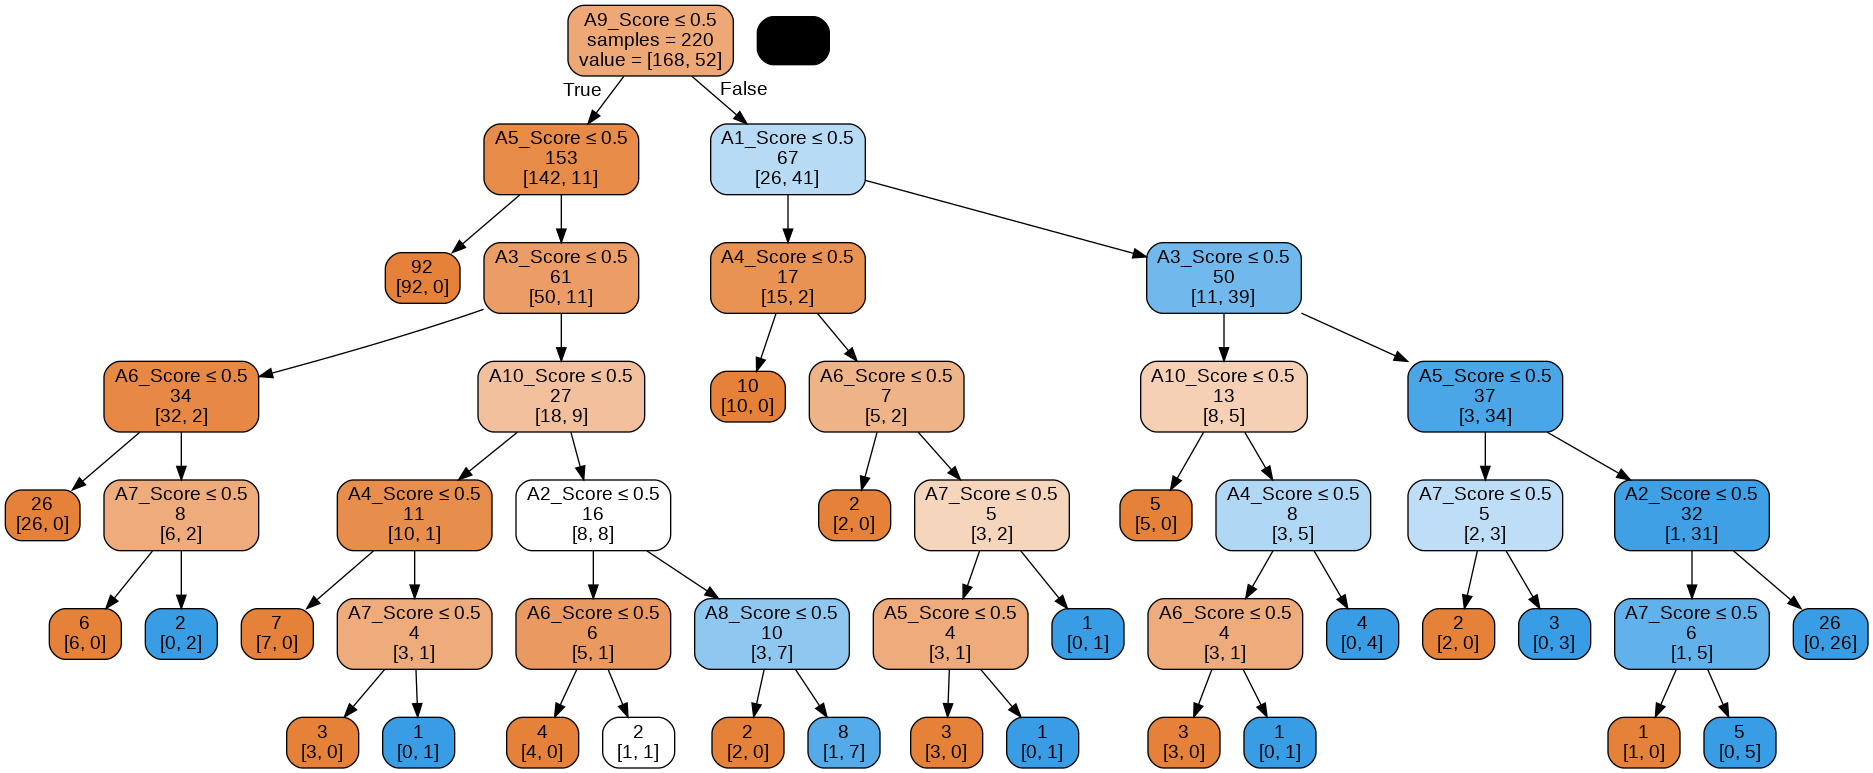

In [ ]:
# Run the optimized tree and plot.
gridClassTree = DecisionTreeClassifier(max_depth=6, 
                                       min_impurity_decrease=0.001, 
                                       min_samples_split=0.01,
                                       random_state=1)
gridClassTree.fit(train_X, train_Y)
plotDecisionTree(gridClassTree, feature_names = train_X.columns)

In [ ]:
# Check model accuracy
classificationSummary(train_Y, gridClassTree.predict(train_X))
classificationSummary(valid_Y, gridClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9909)

       Prediction
Actual   0   1
     0 167   1
     1   1  51
Confusion Matrix (Accuracy 0.9184)

       Prediction
Actual   0   1
     0 107   6
     1   6  28


In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[6, 7, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[300, 400, 500]
} 

In [ ]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [300, 400, 500]})

In [ ]:
# Check for the best parameters
gridsearch.best_params_

{'max_depth': 7,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 0.01,
 'n_estimators': 300}

In [ ]:
# Run the optimized random forest
randomForest = RandomForestClassifier(random_state=1, n_estimators=300, max_depth=7, min_impurity_decrease=0.001, min_samples_split=0.01)
randomForest.fit(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(max_depth=7, min_impurity_decrease=0.001,
                       min_samples_split=0.01, n_estimators=300,
                       random_state=1)

In [ ]:
# Create variables for feature importance and standard deviation
importance = randomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_], axis=0)

In [ ]:
# Check feature importance and standard deviation
randomForest_df = pd.DataFrame({'feature': train_X.columns,
                   'importance': importance,
                   'std': std})
print(randomForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.229473  0.145736
5   A6_Score    0.154952  0.134307
4   A5_Score    0.117172  0.097255
6   A7_Score    0.101293  0.067790
0   A1_Score    0.082952  0.070572
2   A3_Score    0.075834  0.070981
1   A2_Score    0.071954  0.052670
9  A10_Score    0.066632  0.059966
3   A4_Score    0.066248  0.058795
7   A8_Score    0.033489  0.032619


Text(0.5, 1.0, 'Visualizing Important Features')

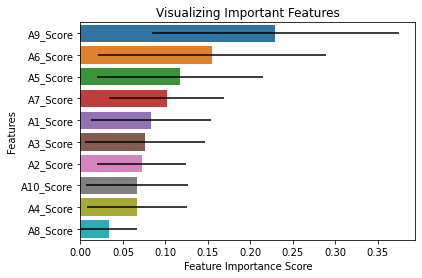

In [ ]:
# Plot feature importance
value_plot = randomForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
# Check model accuracy
classificationSummary(train_Y, randomForest.predict(train_X))
classificationSummary(valid_Y, randomForest.predict(valid_X))

Confusion Matrix (Accuracy 0.9955)

       Prediction
Actual   0   1
     0 168   0
     1   1  51
Confusion Matrix (Accuracy 0.9796)

       Prediction
Actual   0   1
     0 112   1
     1   2  32


In [ ]:
# Run a linear regression
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check model coefficients and odds ratio 
print(pd.DataFrame({'coef': lin_reg.coef_[0], 'odds': np.e**lin_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.136654  1.146432
A2_Score   0.132065  1.141183
A3_Score   0.121464  1.129148
A4_Score   0.100197  1.105388
A5_Score   0.117413  1.124584
A6_Score   0.198354  1.219394
A7_Score   0.163338  1.177435
A8_Score   0.083043  1.086589
A9_Score   0.262441  1.300099
A10_Score  0.077334  1.080403


In [ ]:
# Check model accuracy
regressionSummary(train_Y, lin_reg.predict(train_X))
regressionSummary(valid_Y, lin_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 0.2478
     Mean Absolute Error (MAE) : 0.1984

Regression statistics

               Mean Error (ME) : 0.0240
Root Mean Squared Error (RMSE) : 0.2306
     Mean Absolute Error (MAE) : 0.1882


In [ ]:
# Install shap for visualization
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

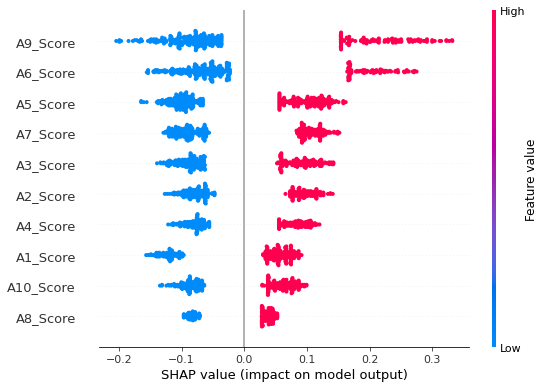

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(lin_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Run a logistic regression with C=1
log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# Check model accuracy
classificationSummary(train_Y, log_reg.predict(train_X))
classificationSummary(valid_Y, log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9591)

       Prediction
Actual   0   1
     0 167   1
     1   8  44
Confusion Matrix (Accuracy 0.9864)

       Prediction
Actual   0   1
     0 113   0
     1   2  32


In [ ]:
# Check variable coefficients and odds ratio
log_result = pd.DataFrame({'coef': log_reg.coef_[0], 'odds': np.e**log_reg.coef_[0]}, index=X.columns)
print(log_result.sort_values('coef', ascending=False))

               coef      odds
A9_Score   1.424485  4.155717
A6_Score   1.125707  3.082396
A7_Score   1.055870  2.874475
A5_Score   0.909666  2.483493
A2_Score   0.804351  2.235245
A3_Score   0.697851  2.009429
A4_Score   0.649822  1.915200
A1_Score   0.639447  1.895432
A10_Score  0.477392  1.611865
A8_Score   0.309754  1.363090


In [ ]:
# Create optional hidden layer sizes for neural network
clf_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=clf_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [ ]:
# Check for best params
gridsearch.best_params_

{'hidden_layer_sizes': 1}

In [ ]:
# Run a neural network with 1 hidden layer
clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=1, random_state=1)
clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=1, random_state=1,
              solver='lbfgs')

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, clf.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 113   0
     1   0  34


<Figure size 720x720 with 0 Axes>

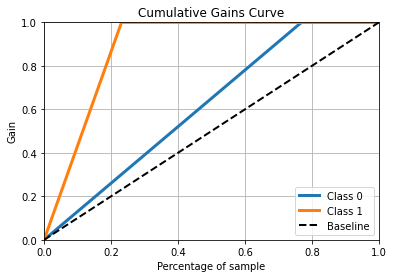

In [ ]:
# Create a variable for model prediction probabilities
pred = clf.predict_proba(valid_X)

# Plot cumulative gains chart
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, pred)
plt.show()

In [ ]:
# Create a new dataset using _Score variables and ID
scores_df = male_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
scores_df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,ID
1,1,1,0,1,0,0,0,1,0,1,1
2,1,1,0,1,1,0,1,1,1,1,2
5,1,1,1,1,1,0,1,1,1,1,5
7,1,1,1,1,0,0,0,0,1,0,7
8,1,1,0,0,1,0,0,1,1,1,8


In [ ]:
# Set ID as the index
scores_df.set_index('ID', inplace=True)
scores_df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
1,1,1,0,1,0,0,0,1,0,1
2,1,1,0,1,1,0,1,1,1,1
5,1,1,1,1,1,0,1,1,1,1
7,1,1,1,1,0,0,0,0,1,0
8,1,1,0,0,1,0,0,1,1,1


In [ ]:
# Check for frequent itemsets using apriori. Minimum frequency is 20%
questionsets = apriori(scores_df, min_support=.2, use_colnames=True)
questionsets.head()

,support,itemsets
0,0.689373,(A1_Score)
1,0.430518,(A2_Score)
2,0.457766,(A3_Score)
3,0.468665,(A4_Score)
4,0.479564,(A5_Score)


In [ ]:
# Use association rules to check for relations between variables
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use minimum 50% confidence as metric
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
100,"(A1_Score, A9_Score)",(A5_Score),0.253406,0.479564,0.207084,0.817204,1.704057,0.085560,2.847091
101,"(A1_Score, A5_Score)",(A9_Score),0.376022,0.326975,0.207084,0.550725,1.684300,0.084135,1.498022
103,(A9_Score),"(A1_Score, A5_Score)",0.326975,0.376022,0.207084,0.633333,1.684300,0.084135,1.701759
123,"(A4_Score, A10_Score)",(A3_Score),0.294278,0.457766,0.215259,0.731481,1.597939,0.080549,2.019355
125,"(A10_Score, A3_Score)",(A4_Score),0.297003,0.468665,0.215259,0.724771,1.546458,0.076064,1.930518


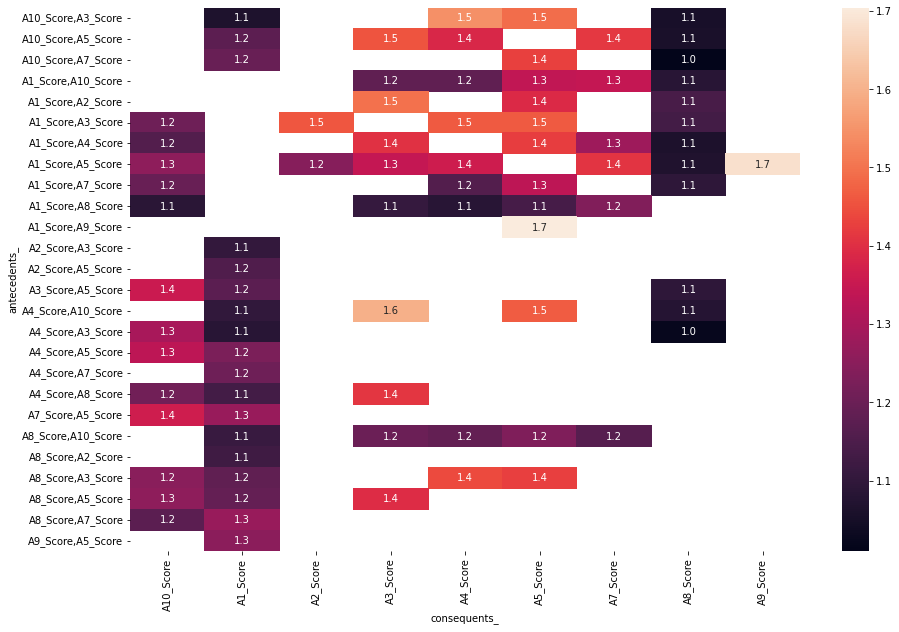

In [ ]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Change value 'White-European' to 'White'
male_df['ethnicity'] = male_df['ethnicity'].replace(['White-European'], 'White')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Create a new dataset for White males.
white_df = male_df[(male_df['ethnicity']=='White')]
white_df.shape

(109, 21)

In [ ]:
# Split the dataset with Class/ASD as target variable and _Score variables as predictors.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= white_df[predictors]
y= white_df[outcome]

X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Create a maximal tree
whiteFullTree = DecisionTreeClassifier(random_state=1)
whiteFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, whiteFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8636)

       Prediction
Actual  0  1
     0 24  2
     1  4 14


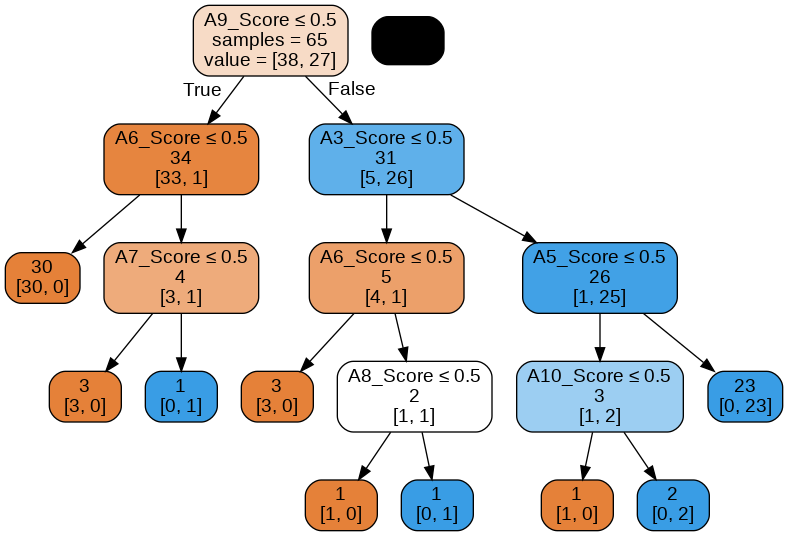

In [ ]:
# Plot the tree
plotDecisionTree(whiteFullTree, feature_names=train_X.columns)

In [ ]:
# Create parameters to optimize the tree
param_grid = {
    'max_depth':[3, 5, 7, 8, 9],
    'min_samples_split': [0.05, 0.01, 0.005, 0.001, 0.0001],
    'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001, 0.005]
} 

In [ ]:
# Run a grid search to find the best parameters.
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8, 9],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001,
                                                   0.005],
                         'min_samples_split': [0.05, 0.01, 0.005, 0.001,
                                               0.0001]})

In [ ]:
# Check for best parameters.
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.05, 'min_samples_split': 0.05}

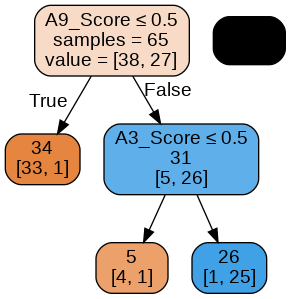

In [ ]:
# Run the optimized tree and plot.
whiteClassTree = DecisionTreeClassifier(max_depth=3, 
                                        min_impurity_decrease=0.05, 
                                        min_samples_split=0.05,
                                        random_state=1)
whiteClassTree.fit(train_X, train_Y)
plotDecisionTree(whiteClassTree, feature_names = train_X.columns)

In [ ]:
# Check accuracy
classificationSummary(valid_Y, whiteClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8409)

       Prediction
Actual  0  1
     0 24  2
     1  5 13


In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[6, 7, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [ ]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 6,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 300}

In [ ]:
# Run a random forest
whiteForest = RandomForestClassifier(random_state=1, n_estimators=300, max_depth=6, min_impurity_decrease=0.01, min_samples_split=0.05)
whiteForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=6, min_impurity_decrease=0.01,
                       min_samples_split=0.05, n_estimators=300,
                       random_state=1)

In [ ]:
# Check variable importance and standard deviation
importance = whiteForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in whiteForest.estimators_], axis=0)

whiteForest_df = pd.DataFrame({'feature': train_X.columns,
                               'importance': importance,
                               'std': std})
print(whiteForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.342878  0.337865
5   A6_Score    0.247640  0.313141
4   A5_Score    0.126992  0.209975
9  A10_Score    0.092578  0.161183
2   A3_Score    0.082540  0.145127
3   A4_Score    0.037802  0.105161
1   A2_Score    0.026167  0.069943
0   A1_Score    0.015607  0.055966
7   A8_Score    0.014667  0.041931
6   A7_Score    0.013129  0.040283


Text(0.5, 1.0, 'Visualizing Important Features')

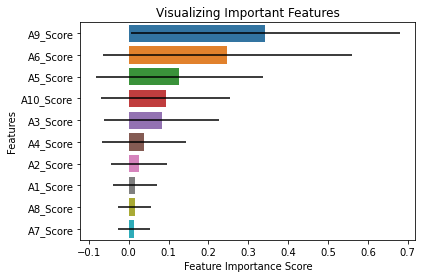

In [ ]:
# Plot feature importance
value_plot = whiteForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
# Check accuracy
print(classification_report(valid_Y, whiteForest.predict(valid_X)))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.88      0.83      0.86        18

    accuracy                           0.89        44
   macro avg       0.89      0.88      0.88        44
weighted avg       0.89      0.89      0.89        44



In [ ]:
# Create optional hidden layer sizes for neural network
whiteCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
# Run a grid search to find optimal hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=whiteCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'hidden_layer_sizes': 4}

In [ ]:
# Run a neural network with 4 hidden layers
white_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=4, random_state=1)
white_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=4, random_state=1,
              solver='lbfgs')

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, white_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8636)

       Prediction
Actual  0  1
     0 23  3
     1  3 15


<Figure size 720x720 with 0 Axes>

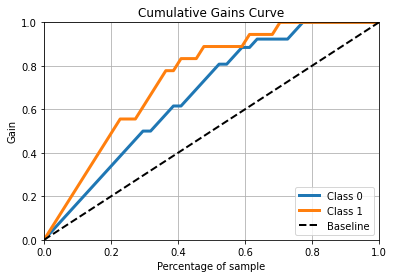

In [ ]:
white_clf_pred = white_clf.predict_proba(valid_X)

# Plot cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, white_clf_pred)
plt.show()

In [ ]:
# Run a linear regression
white_reg = LinearRegression()
white_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check accuracy
regressionSummary(valid_Y, white_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0192
Root Mean Squared Error (RMSE) : 0.3233
     Mean Absolute Error (MAE) : 0.2162


In [ ]:
# Check variabel coefficients and odds ratios
print(pd.DataFrame({'coef': white_reg.coef_[0], 'odds': np.e**white_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.010680  0.989377
A2_Score   0.028733  1.029150
A3_Score   0.169224  1.184386
A4_Score   0.021118  1.021342
A5_Score   0.064924  1.067078
A6_Score   0.296390  1.344994
A7_Score   0.061124  1.063030
A8_Score   0.114914  1.121776
A9_Score   0.394473  1.483603
A10_Score  0.112982  1.119612


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

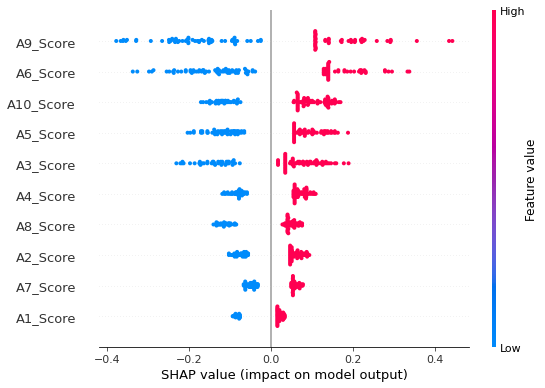

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(white_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Run a logistic regression
white_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
white_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# Check accuracy
classificationSummary(valid_Y, white_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8409)

       Prediction
Actual  0  1
     0 22  4
     1  3 15


In [ ]:
# Check variable coefficients and odds ratios
white_result = pd.DataFrame({'coef': white_log_reg.coef_[0], 'odds': np.e**white_log_reg.coef_[0]}, index=X.columns)
print(white_result.sort_values('odds', ascending=False))

               coef      odds
A9_Score   1.607627  4.990951
A6_Score   1.353457  3.870785
A10_Score  0.643937  1.903963
A5_Score   0.624552  1.867410
A3_Score   0.617115  1.853572
A7_Score   0.259470  1.296243
A4_Score   0.252409  1.287122
A2_Score   0.201085  1.222729
A8_Score   0.093979  1.098536
A1_Score  -0.568070  0.566618


In [ ]:
# Create a dataset using _Score variables an ID. 
white_scores = white_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
# Set ID as index.
white_scores.set_index('ID', inplace=True)
white_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
7,1,1,1,1,0,0,0,0,1,0
8,1,1,0,0,1,0,0,1,1,1
10,1,1,1,1,1,1,1,1,1,1
17,0,0,0,0,0,0,0,1,0,1
30,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check itemset frequency using apriori
questionsets = apriori(white_scores, min_support=.25, use_colnames=True) # Set minimum threshold to 25% frequency.
questionsets.head()

,support,itemsets
0,0.761468,(A1_Score)
1,0.623853,(A2_Score)
2,0.623853,(A3_Score)
3,0.614679,(A4_Score)
4,0.532110,(A5_Score)


In [ ]:
# Check variable relationships using association rules. 
white_rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Set metric as 'confidence' with a threshold of 50%.
white_rules.sort_values(by=['lift'], ascending=False).head() # Order by Lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2759,"(A10_Score, A9_Score)","(A4_Score, A8_Score, A6_Score)",0.385321,0.266055,0.256881,0.666667,2.505747,0.154364,2.201835
2744,"(A4_Score, A8_Score, A6_Score)","(A10_Score, A9_Score)",0.266055,0.385321,0.256881,0.965517,2.505747,0.154364,17.825688
2026,"(A2_Score, A9_Score)","(A1_Score, A6_Score, A3_Score)",0.330275,0.311927,0.256881,0.777778,2.493464,0.153859,3.096330
2011,"(A1_Score, A6_Score, A3_Score)","(A2_Score, A9_Score)",0.311927,0.330275,0.256881,0.823529,2.493464,0.153859,3.795107
2024,"(A9_Score, A3_Score)","(A1_Score, A2_Score, A6_Score)",0.376147,0.275229,0.256881,0.682927,2.481301,0.153354,2.285815


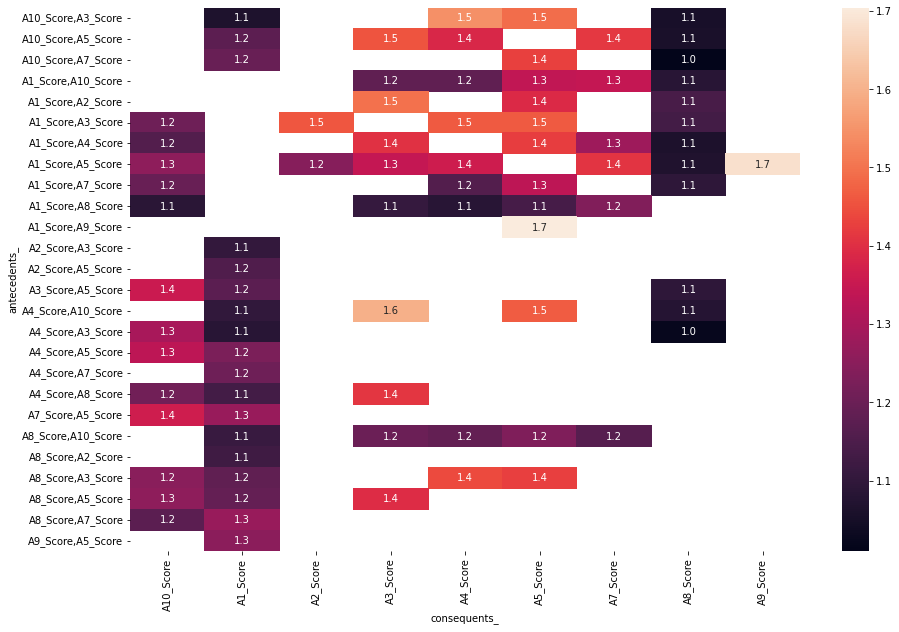

In [ ]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Create dataset for Black females
black_df = male_df[(male_df['ethnicity']=='Black')]
black_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
28,28,0,0,0,0,0,0,0,1,0,...,48,m,Black,no,no,New Zealand,no,1,Self,NO
68,68,0,0,0,0,1,0,0,0,0,...,42,m,Black,no,no,New Zealand,no,1,Self,NO
130,130,1,0,0,0,0,0,0,1,0,...,24,m,Black,no,no,Ethiopia,no,3,Self,NO
233,233,0,1,1,0,0,0,0,0,0,...,24,m,Black,no,no,New Zealand,no,2,Self,NO
439,439,1,0,1,1,1,0,1,0,0,...,17,m,Black,no,no,United States,no,6,Relative,NO


In [ ]:
# Split the dataset with Class/ASD as the target variable.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= black_df[predictors]
y= black_df[outcome]
# Convert categorical variables to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Create a maximal tree
blackFullTree = DecisionTreeClassifier(random_state=1)
blackFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check accuracy
classificationSummary(valid_Y, blackFullTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0 1
     0 5 0
     1 0 3


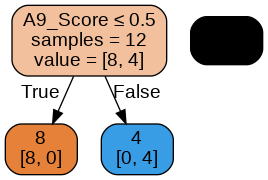

In [ ]:
# Plot the tree
plotDecisionTree(blackFullTree, feature_names=train_X.columns)

In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[3, 5, 6, 7],
    'min_samples_split': [0.07, 0.05, 0.01],
    'min_impurity_decrease': [0.05, 0.01, 0.001],
    'n_estimators':[200, 300, 400]
} 

In [ ]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'min_impurity_decrease': [0.05, 0.01, 0.001],
                         'min_samples_split': [0.07, 0.05, 0.01],
                         'n_estimators': [200, 300, 400]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3,
 'min_impurity_decrease': 0.05,
 'min_samples_split': 0.07,
 'n_estimators': 200}

In [ ]:
# Run a random forest
blackForest = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=3, min_impurity_decrease=0.05, min_samples_split=0.07)
blackForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=3, min_impurity_decrease=0.05,
                       min_samples_split=0.07, n_estimators=200,
                       random_state=1)

In [ ]:
# Check importance and standard deviation for features
importance = blackForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in blackForest.estimators_], axis=0)

blackForest_df = pd.DataFrame({'feature': train_X.columns,
                               'importance': importance,
                               'std': std})
print(blackForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.410252  0.454856
2   A3_Score    0.130832  0.263082
9  A10_Score    0.108169  0.247743
5   A6_Score    0.097091  0.257298
4   A5_Score    0.081340  0.187244
0   A1_Score    0.073948  0.194287
6   A7_Score    0.034683  0.128296
7   A8_Score    0.027393  0.100314
1   A2_Score    0.018276  0.066062
3   A4_Score    0.018017  0.090016


Text(0.5, 1.0, 'Visualizing Important Features')

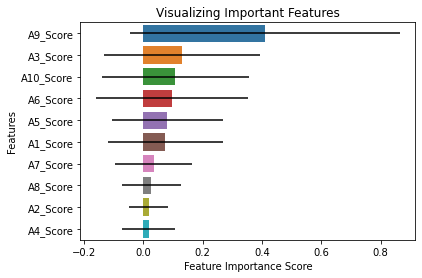

In [ ]:
# Plot feature importance
value_plot = blackForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
# Check accuracy
classificationSummary(valid_Y, blackForest.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0 1
     0 5 0
     1 0 3


In [ ]:
# Create optional hidden layer sizes for neural network
blackCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
# Run a grid search to find optimal hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=blackCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 4 members, which is less than n_splits=5.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [ ]:
# Find best layer size
gridsearch.best_params_

{'hidden_layer_sizes': 2}

In [ ]:
# Run a neural network with 2 hidden layers
black_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=2, random_state=1)
black_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=2, random_state=1,
              solver='lbfgs')

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, black_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8750)

       Prediction
Actual 0 1
     0 4 1
     1 0 3


<Figure size 720x720 with 0 Axes>

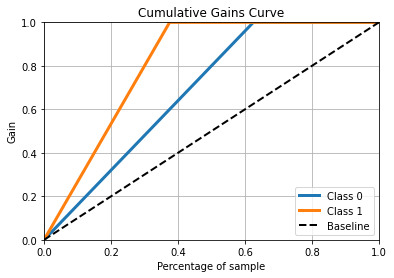

In [ ]:
black_clf_pred = black_clf.predict_proba(valid_X)

# Plot cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, black_clf_pred)
plt.show()

In [ ]:
# Run a linear regression
black_reg = LinearRegression()
black_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check variable coefficients and odds ratios
print(pd.DataFrame({'coef': black_reg.coef_[0], 'odds': np.e**black_reg.coef_[0]}, index=X.columns))

                   coef      odds
A1_Score  -4.913404e-16  1.000000
A2_Score   1.110223e-16  1.000000
A3_Score   1.110223e-16  1.000000
A4_Score   2.220446e-16  1.000000
A5_Score   2.664535e-15  1.000000
A6_Score   2.081668e-15  1.000000
A7_Score  -8.743006e-16  1.000000
A8_Score  -2.588207e-15  1.000000
A9_Score   1.000000e+00  2.718282
A10_Score -2.220446e-15  1.000000


In [ ]:
# Check accuracy
regressionSummary(valid_Y, black_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 0.0000
     Mean Absolute Error (MAE) : 0.0000


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

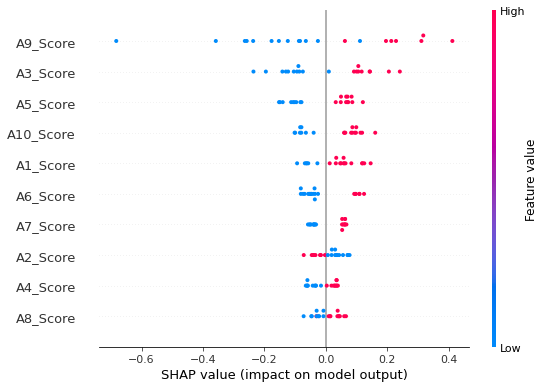

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(black_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Run a logistic regression
black_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
black_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': black_log_reg.coef_[0], 'odds': np.e**black_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.212778  1.237109
A2_Score  -0.442746  0.642270
A3_Score   0.396077  1.485983
A4_Score  -0.098976  0.905764
A5_Score   0.184026  1.202047
A6_Score   0.415306  1.514834
A7_Score   0.127250  1.135701
A8_Score  -0.201792  0.817265
A9_Score   1.044013  2.840592
A10_Score  0.328076  1.388295


In [ ]:
# Check accuracy
classificationSummary(valid_Y, black_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8750)

       Prediction
Actual 0 1
     0 4 1
     1 0 3


In [ ]:
# Create dataset with _Score variables and ID
black_scores = black_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
# Set ID column as index
black_scores.set_index('ID', inplace=True)
black_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
28,0,0,0,0,0,0,0,1,0,0
68,0,0,0,0,1,0,0,0,0,0
130,1,0,0,0,0,0,0,1,0,1
233,0,1,1,0,0,0,0,0,0,0
439,1,0,1,1,1,0,1,0,0,1


In [ ]:
# Identify frequent itemsets using apriori
questionsets = apriori(black_scores, min_support=.2, use_colnames=True) # min_support for itemsets is 20%.
questionsets.head()

,support,itemsets
0,0.70,(A1_Score)
1,0.40,(A2_Score)
2,0.45,(A3_Score)
3,0.50,(A4_Score)
4,0.55,(A5_Score)


In [ ]:
# Check for relationships between _Scores using association rules. Set metric as 'confidence' and min_threshold at 50%.
black_rules = association_rules(questionsets, metric='confidence', min_threshold=0.5)
# Sort values by lift
black_rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2356,"(A9_Score, A6_Score)","(A1_Score, A8_Score, A10_Score, A5_Score)",0.25,0.25,0.2,0.8,3.2,0.1375,3.75
1954,"(A8_Score, A10_Score, A5_Score)","(A9_Score, A6_Score)",0.25,0.25,0.2,0.8,3.2,0.1375,3.75
2312,"(A1_Score, A8_Score, A10_Score, A5_Score)","(A9_Score, A6_Score)",0.25,0.25,0.2,0.8,3.2,0.1375,3.75
1972,"(A9_Score, A6_Score)","(A8_Score, A10_Score, A5_Score)",0.25,0.25,0.2,0.8,3.2,0.1375,3.75
2336,"(A8_Score, A10_Score, A5_Score)","(A1_Score, A9_Score, A6_Score)",0.25,0.25,0.2,0.8,3.2,0.1375,3.75


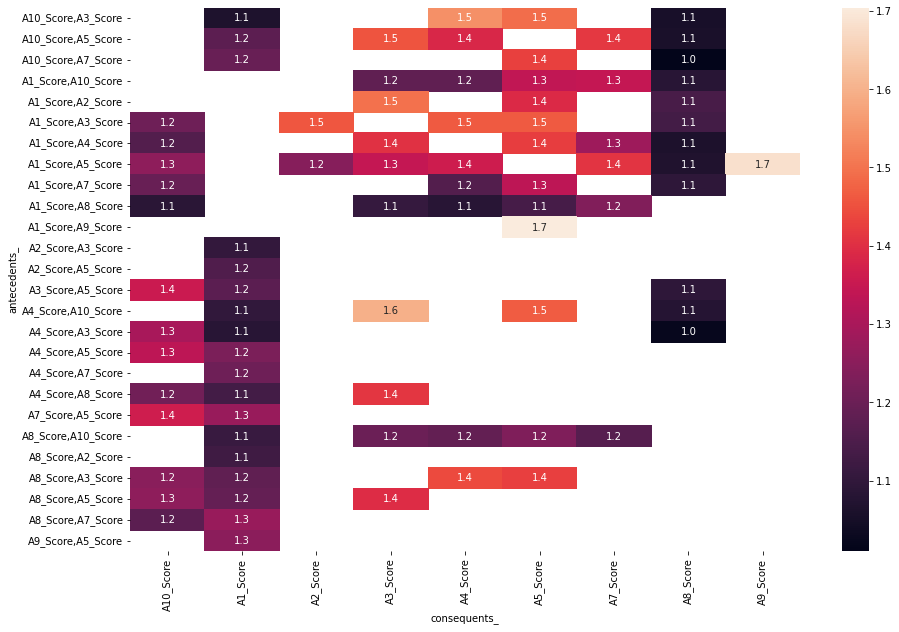

In [ ]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Create dataset for Asian ethnicity
asian_df = male_df[(male_df['ethnicity']=='Asian')]
asian_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
9,9,1,1,1,1,0,1,1,1,1,...,17,m,Asian,yes,yes,Bahamas,no,8,Health care professional,YES
70,70,0,0,1,1,0,0,0,1,0,...,58,m,Asian,no,no,New Zealand,no,3,Self,NO
101,101,1,0,0,0,0,0,0,0,1,...,26,m,Asian,no,no,New Zealand,no,3,Self,NO
102,102,1,1,0,0,1,0,1,1,0,...,26,m,Asian,no,no,India,no,5,Self,NO
104,104,0,0,0,0,0,0,0,0,0,...,25,m,Asian,no,no,India,no,0,Self,NO


In [ ]:
# Split the dataset with Class/ASD as the target variable
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= asian_df[predictors]
y= asian_df[outcome]
# Convert categorical variables to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Run a maximal tree
asianFullTree = DecisionTreeClassifier(random_state=1)
asianFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check accuracy
classificationSummary(valid_Y, asianFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9310)

       Prediction
Actual  0  1
     0 25  1
     1  1  2


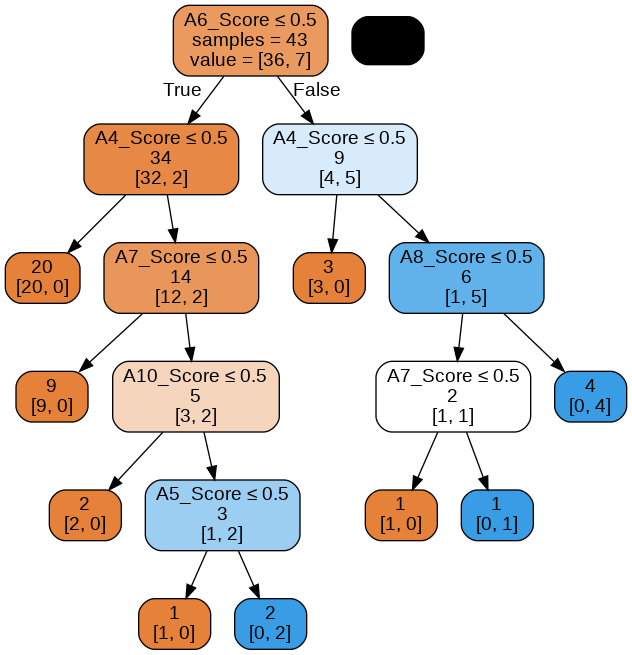

In [ ]:
# Plot the decision Tree
plotDecisionTree(asianFullTree, feature_names=train_X.columns)

In [ ]:
# Set parameters to optimize the decision tree
param_grid = {
    'max_depth':[3, 5, 6, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [ ]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

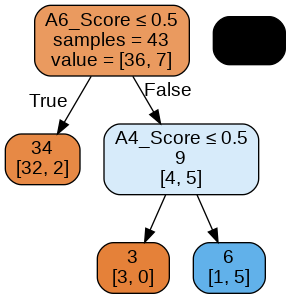

In [ ]:
# Run the optimized tree and plot
asianClassTree = DecisionTreeClassifier(max_depth=3, 
                                        min_impurity_decrease=0.02, 
                                        min_samples_split=0.07,
                                        random_state=1)
asianClassTree.fit(train_X, train_Y)
plotDecisionTree(asianClassTree, feature_names = train_X.columns)

In [ ]:
# Check accuracy
classificationSummary(valid_Y, asianClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8966)

       Prediction
Actual  0  1
     0 25  1
     1  2  1


In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[6, 7, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [ ]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 6,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 0.05,
 'n_estimators': 300}

In [ ]:
# Run a random forest
asianForest = RandomForestClassifier(random_state=1, n_estimators=300, max_depth=6, min_impurity_decrease=0.001, min_samples_split=0.05)
asianForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=6, min_impurity_decrease=0.001,
                       min_samples_split=0.05, n_estimators=300,
                       random_state=1)

In [ ]:
# Check feature importance and standard deviation
importance = randomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_], axis=0)

asianForest_df = pd.DataFrame({'feature': train_X.columns,
                               'importance': importance,
                               'std': std})
print(asianForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.229473  0.145736
5   A6_Score    0.154952  0.134307
4   A5_Score    0.117172  0.097255
6   A7_Score    0.101293  0.067790
0   A1_Score    0.082952  0.070572
2   A3_Score    0.075834  0.070981
1   A2_Score    0.071954  0.052670
9  A10_Score    0.066632  0.059966
3   A4_Score    0.066248  0.058795
7   A8_Score    0.033489  0.032619


Text(0.5, 1.0, 'Visualizing Important Features')

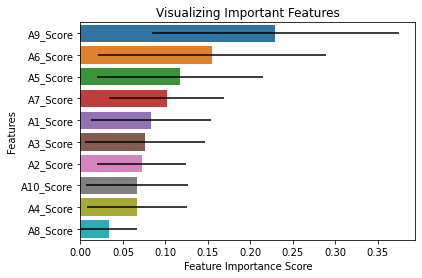

In [ ]:
# Plot feature importance
value_plot = asianForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
# Check accuracy
classificationSummary(valid_Y, asianForest.predict(valid_X))

Confusion Matrix (Accuracy 0.9655)

       Prediction
Actual  0  1
     0 26  0
     1  1  2


In [ ]:
# Create optional hidden layer sizes for neural network
asianCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=asianCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [ ]:
# Check optimal hidden layer size
gridsearch.best_params_

{'hidden_layer_sizes': 1}

In [ ]:
# Run a neural network with 1 hidden layer
asian_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=1, random_state=1)
asian_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=1, random_state=1,
              solver='lbfgs')

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, asian_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8966)

       Prediction
Actual  0  1
     0 24  2
     1  1  2


<Figure size 720x720 with 0 Axes>

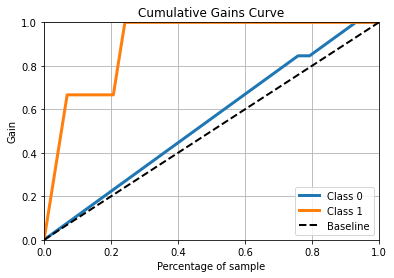

In [ ]:
asian_clf_pred = asian_clf.predict_proba(valid_X)

# Plot the cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, asian_clf_pred)
plt.show()

In [ ]:
# Run a linear regression
asian_reg = LinearRegression()
asian_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': asian_reg.coef_[0], 'odds': np.e**asian_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.003753  0.996254
A2_Score  -0.054081  0.947355
A3_Score   0.136772  1.146566
A4_Score   0.209145  1.232623
A5_Score   0.084593  1.088274
A6_Score   0.300683  1.350781
A7_Score   0.216859  1.242168
A8_Score   0.087900  1.091879
A9_Score   0.165349  1.179804
A10_Score  0.024065  1.024357


In [ ]:
# Check accuracy
regressionSummary(valid_Y, asian_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0209
Root Mean Squared Error (RMSE) : 0.2509
     Mean Absolute Error (MAE) : 0.1784


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

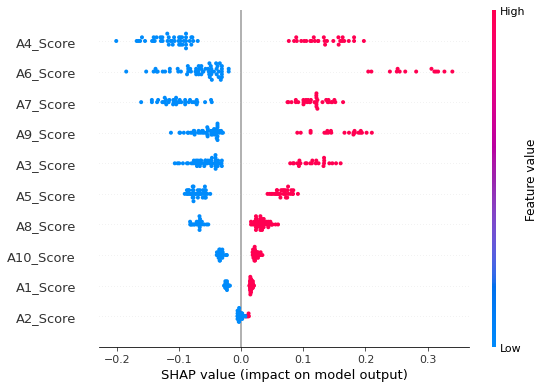

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(asian_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Run a logistic regression
asian_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
asian_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': asian_log_reg.coef_[0], 'odds': np.e**asian_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.328343  0.720116
A2_Score  -0.396814  0.672459
A3_Score   0.336654  1.400254
A4_Score   0.784441  2.191182
A5_Score   0.245782  1.278621
A6_Score   1.016027  2.762198
A7_Score   0.670832  1.955864
A8_Score  -0.175521  0.839020
A9_Score   0.603510  1.828526
A10_Score -0.298877  0.741650


In [ ]:
# Check accuracy
classificationSummary(valid_Y, asian_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9310)

       Prediction
Actual  0  1
     0 26  0
     1  2  1


In [ ]:
# Create a dataset using _Score variables and ID. Set ID as index.
asian_scores = asian_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
asian_scores.set_index('ID', inplace=True)
asian_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
9,1,1,1,1,0,1,1,1,1,0
70,0,0,1,1,0,0,0,1,0,0
101,1,0,0,0,0,0,0,0,1,1
102,1,1,0,0,1,0,1,1,0,0
104,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check for frequent itemsets using apriori
questionsets = apriori(asian_scores, min_support=.15, use_colnames=True) # Set minimum support to 15%.
questionsets.head()

,support,itemsets
0,0.625000,(A1_Score)
1,0.250000,(A2_Score)
2,0.333333,(A3_Score)
3,0.388889,(A4_Score)
4,0.444444,(A5_Score)


In [ ]:
# Check for relations between _Scores using association rules
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use confidence as the metric with 50% minimum threshold.
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
86,"(A10_Score, A7_Score)","(A1_Score, A5_Score)",0.277778,0.305556,0.152778,0.550000,1.800000,0.067901,1.543210
85,"(A1_Score, A5_Score)","(A10_Score, A7_Score)",0.305556,0.277778,0.152778,0.500000,1.800000,0.067901,1.444444
81,"(A1_Score, A10_Score, A7_Score)",(A5_Score),0.194444,0.444444,0.152778,0.785714,1.767857,0.066358,2.592593
74,"(A1_Score, A8_Score, A5_Score)",(A7_Score),0.222222,0.486111,0.180556,0.812500,1.671429,0.072531,2.740741
88,"(A7_Score, A5_Score)","(A1_Score, A10_Score)",0.277778,0.333333,0.152778,0.550000,1.650000,0.060185,1.481481


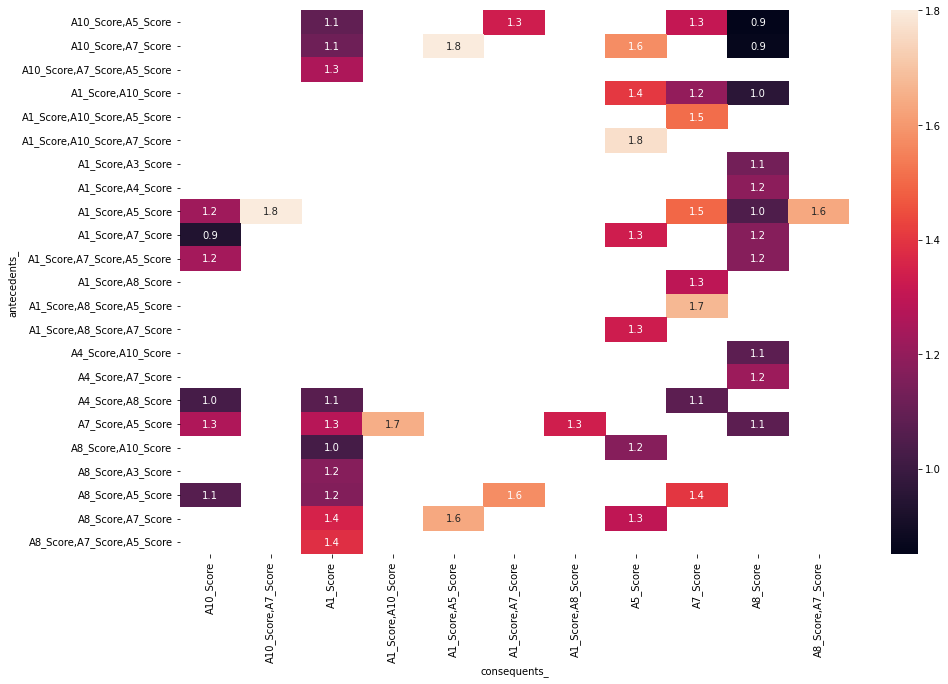

In [ ]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Create a dataset for South Asian ethnicity
sasian_df = male_df[(male_df['ethnicity']=='South Asian')]
sasian_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
103,103,0,0,0,0,1,1,0,1,0,...,21,m,South Asian,no,no,India,no,4,Self,NO
105,105,0,0,1,0,1,1,1,1,0,...,26,m,South Asian,no,no,New Zealand,no,6,Self,NO
131,131,1,1,0,0,0,0,0,1,0,...,23,m,South Asian,no,no,India,no,3,Self,NO
140,140,1,0,0,0,0,0,0,1,0,...,29,m,South Asian,no,no,India,no,2,Self,NO
143,143,0,0,0,0,0,0,0,1,0,...,22,m,South Asian,no,no,New Zealand,no,1,Self,NO


In [ ]:
# Split the dataset with Class/ASD as the target variable.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= sasian_df[predictors]
y= sasian_df[outcome]
# Convert catergorical variables to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Create a maximal tree
sasianFullTree = DecisionTreeClassifier(random_state=1)
sasianFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check for accuracy
classificationSummary(valid_Y, sasianFullTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 7


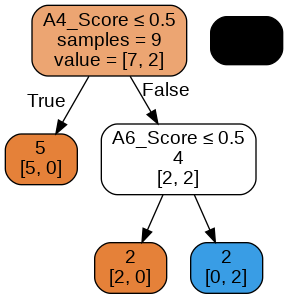

In [ ]:
# Plot the tree
plotDecisionTree(sasianFullTree, feature_names=train_X.columns)

In [ ]:
# Create parameters to optimize the tree
param_grid = {
    'max_depth':[3, 5, 6, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [ ]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 2 members, which is less than n_splits=5.


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

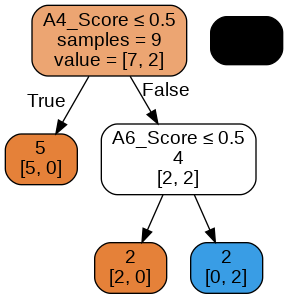

In [ ]:
# Create the optimized tree and plot.
sasianClassTree = DecisionTreeClassifier(max_depth=3, 
                                         min_impurity_decrease=0.02, 
                                         min_samples_split=0.07,
                                         random_state=1)
sasianClassTree.fit(train_X, train_Y)
plotDecisionTree(sasianClassTree, feature_names = train_X.columns)

In [ ]:
# Check accuracy
classificationSummary(valid_Y, sasianClassTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 7


In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[3, 5, 6, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [ ]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 2 members, which is less than n_splits=3.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 100}

In [ ]:
# Run a random forest
sasianForest = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=3, min_impurity_decrease=0.01, min_samples_split=0.05)
sasianForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=3, min_impurity_decrease=0.01,
                       min_samples_split=0.05, random_state=1)

In [ ]:
# Check for variable importance and standard deviation.
importance = sasianForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in sasianForest.estimators_], axis=0)

sasianForest_df = pd.DataFrame({'feature': train_X.columns,
                                'importance': importance,
                                'std': std})
print(sasianForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.216118  0.278073
5   A6_Score    0.177443  0.265357
3   A4_Score    0.155311  0.256579
9  A10_Score    0.117059  0.231878
2   A3_Score    0.105478  0.210986
7   A8_Score    0.070804  0.171376
6   A7_Score    0.062487  0.148969
4   A5_Score    0.046667  0.134751
1   A2_Score    0.033702  0.122297
0   A1_Score    0.014931  0.071236


Text(0.5, 1.0, 'Visualizing Important Features')

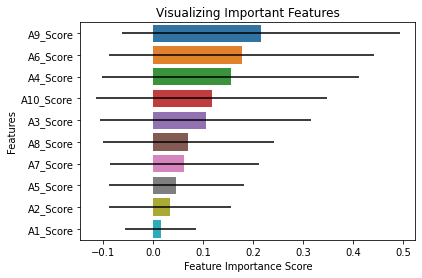

In [ ]:
# Plot feature importance
value_plot = sasianForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
# Check accuracy
classificationSummary(valid_Y, sasianForest.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 7


In [ ]:
# Create optional hidden layer sizes for neural network
sasianCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=sasianCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 2 members, which is less than n_splits=5.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [ ]:
# Check for best optimizer
gridsearch.best_params_

{'hidden_layer_sizes': 2}

In [ ]:
# Run a neural network with 2 hidden layers
sasian_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=2, random_state=1)
sasian_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=2, random_state=1,
              solver='lbfgs')

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, sasian_clf.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 7


In [ ]:
# Run a linear regression
sasian_reg = LinearRegression()
sasian_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': sasian_reg.coef_[0], 'odds': np.e**sasian_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   1.020833  2.775507
A2_Score  -0.562500  0.569783
A3_Score  -0.093750  0.910510
A4_Score   0.885417  2.423994
A5_Score   0.020833  1.021052
A6_Score   1.208333  3.347900
A7_Score   0.093750  1.098285
A8_Score  -0.208333  0.811936
A9_Score  -1.000000  0.367879
A10_Score  0.114583  1.121406


In [ ]:
# Check accuracy
regressionSummary(valid_Y, sasian_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.4821
Root Mean Squared Error (RMSE) : 0.6423
     Mean Absolute Error (MAE) : 0.4821


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

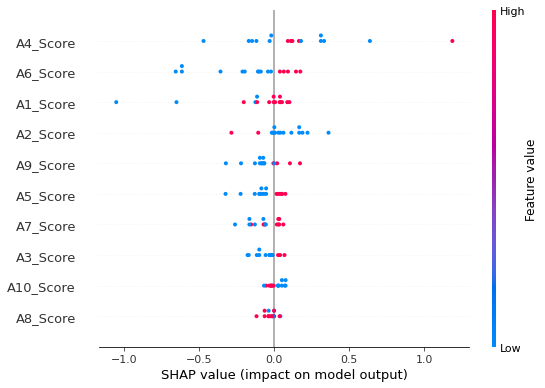

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(sasian_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Run a logistic regression
sasian_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
sasian_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': sasian_log_reg.coef_[0], 'odds': np.e**sasian_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.249032  0.779555
A2_Score  -0.250440  0.778458
A3_Score  -0.038015  0.962698
A4_Score   0.469511  1.599212
A5_Score   0.001787  1.001788
A6_Score   0.363227  1.437962
A7_Score  -0.022750  0.977506
A8_Score  -0.315104  0.729713
A9_Score   0.456150  1.577987
A10_Score -0.591056  0.553742


In [ ]:
# Check accuracy
classificationSummary(valid_Y, sasian_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 7


In [ ]:
# Create a dataset using _Score variables and ID. Set ID as the index.
sasian_scores = sasian_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
sasian_scores.set_index('ID', inplace=True)
sasian_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
103,0,0,0,0,1,1,0,1,0,1
105,0,0,1,0,1,1,1,1,0,1
131,1,1,0,0,0,0,0,1,0,0
140,1,0,0,0,0,0,0,1,0,0
143,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Check for frequent itemsets using apriori.
questionsets = apriori(sasian_scores, min_support=.185, use_colnames=True) # Set support to 18.5% frequency.
questionsets.head()

,support,itemsets
0,0.7500,(A1_Score)
1,0.1875,(A3_Score)
2,0.3125,(A4_Score)
3,0.3750,(A5_Score)
4,0.3125,(A6_Score)


In [ ]:
# Check for relations between _Score variables using association rules.
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use confidence as the metric with a min threshold of 50%.
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
186,"(A9_Score, A7_Score)","(A4_Score, A5_Score)",0.1875,0.1875,0.1875,1.0,5.333333,0.152344,inf
226,"(A9_Score, A7_Score)","(A4_Score, A1_Score, A5_Score)",0.1875,0.1875,0.1875,1.0,5.333333,0.152344,inf
217,"(A1_Score, A9_Score, A7_Score)","(A4_Score, A5_Score)",0.1875,0.1875,0.1875,1.0,5.333333,0.152344,inf
185,"(A4_Score, A5_Score)","(A9_Score, A7_Score)",0.1875,0.1875,0.1875,1.0,5.333333,0.152344,inf
222,"(A4_Score, A5_Score)","(A1_Score, A9_Score, A7_Score)",0.1875,0.1875,0.1875,1.0,5.333333,0.152344,inf


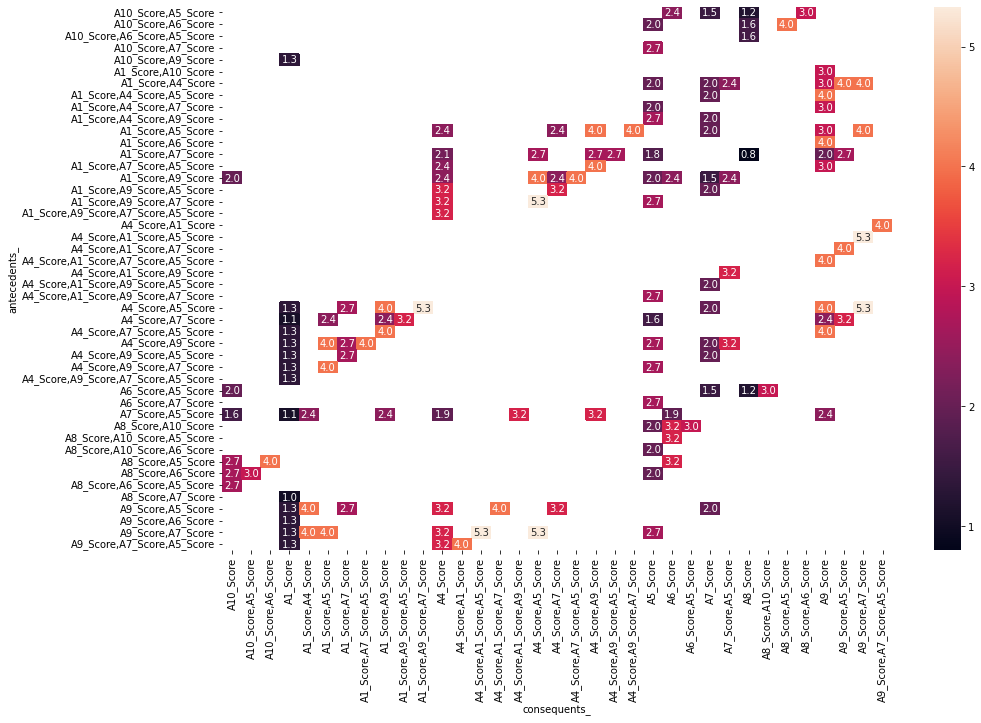

In [ ]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Replace value 'Middle Eastern ' with 'Middle Eastern'
male_df['ethnicity'] = male_df['ethnicity'].replace(['Middle Eastern '], 'Middle Eastern')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Create dataset for Middle Eastern ethnicity
eastern_df = male_df[(male_df['ethnicity']=='Middle Eastern')]
eastern_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
15,15,1,1,0,1,1,0,0,1,0,...,18,m,Middle Eastern,no,yes,New Zealand,no,6,Parent,NO
16,16,1,0,0,0,0,0,1,1,1,...,31,m,Middle Eastern,no,no,Jordan,no,5,Self,NO
22,22,0,0,0,1,0,0,1,1,1,...,27,m,Middle Eastern,no,no,Afghanistan,no,5,Self,NO
23,23,0,0,0,0,0,0,0,1,0,...,42,m,Middle Eastern,yes,no,United Arab Emirates,no,2,Relative,NO
27,27,0,0,0,0,0,0,0,1,0,...,40,m,Middle Eastern,yes,yes,Afghanistan,no,1,Parent,NO


In [ ]:
# Split the dataset with Class/ASD as the target variable.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= eastern_df[predictors]
y= eastern_df[outcome]

X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Create a maximal tree
easternFullTree = DecisionTreeClassifier(random_state=1)
easternFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check for accuracy
classificationSummary(valid_Y, easternFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9545)

       Prediction
Actual  0  1
     0 21  0
     1  1  0


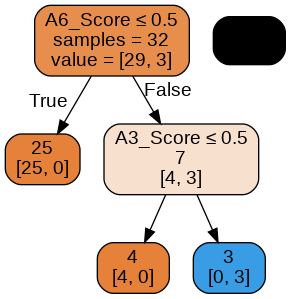

In [ ]:
# plot the tree
plotDecisionTree(easternFullTree, feature_names=train_X.columns)

In [ ]:
# Create decision tree parameters
param_grid = {
    'max_depth':[3, 5, 6, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [ ]:
# Run a grid search to find optimal parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 3 members, which is less than n_splits=5.


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

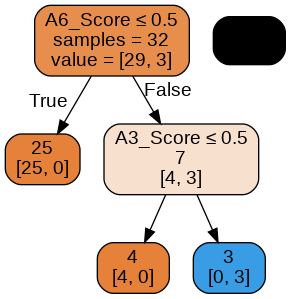

In [ ]:
# Plot the optimized tree
easternClassTree = DecisionTreeClassifier(max_depth=3, 
                                          min_impurity_decrease=0.02, 
                                          min_samples_split=0.07,
                                          random_state=1)
easternClassTree.fit(train_X, train_Y)
plotDecisionTree(easternClassTree, feature_names = train_X.columns)

In [ ]:
# Check accuracy
classificationSummary(valid_Y, easternClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9545)

       Prediction
Actual  0  1
     0 21  0
     1  1  0


In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[3, 5, 6, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [ ]:
# Run a grid search to find optimal parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [ ]:
# Check best parameters
gridsearch.best_params_

{'max_depth': 3,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 100}

In [ ]:
# Run a random forest
easternForest = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=3, min_impurity_decrease=0.01, min_samples_split=0.05)
easternForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=3, min_impurity_decrease=0.01,
                       min_samples_split=0.05, random_state=1)

In [ ]:
# Check variable importance and standard deviation
importance = easternForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in easternForest.estimators_], axis=0)

easternForest_df = pd.DataFrame({'feature': train_X.columns,
                                 'importance': importance,
                                 'std': std})
print(easternForest_df.sort_values('importance', ascending=False))

     feature  importance       std
5   A6_Score    0.313220  0.312323
1   A2_Score    0.226023  0.234442
2   A3_Score    0.102182  0.185085
7   A8_Score    0.071504  0.137689
9  A10_Score    0.061536  0.143769
6   A7_Score    0.059361  0.134062
8   A9_Score    0.048914  0.102591
4   A5_Score    0.046637  0.098629
3   A4_Score    0.039700  0.102714
0   A1_Score    0.030922  0.095400


Text(0.5, 1.0, 'Visualizing Important Features')

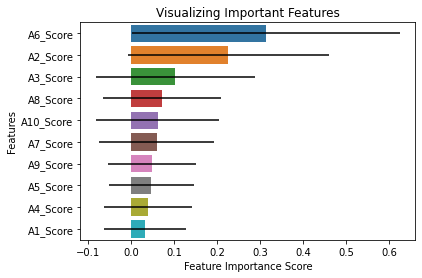

In [ ]:
# Plot feature importance
value_plot = easternForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
# Check accuracy
classificationSummary(valid_Y, easternForest.predict(valid_X))

Confusion Matrix (Accuracy 0.9545)

       Prediction
Actual  0  1
     0 21  0
     1  1  0


In [ ]:
# Create optional hidden layer sizes for neural network
easternCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=easternCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 3 members, which is less than n_splits=5.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [ ]:
# Find optimal hidden layer size
gridsearch.best_params_

{'hidden_layer_sizes': 7}

In [ ]:
# Run a neural network with 7 hidden layers
eastern_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=7, random_state=1)
eastern_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=7, random_state=1,
              solver='lbfgs')

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, eastern_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.9545)

       Prediction
Actual  0  1
     0 21  0
     1  1  0


<Figure size 720x720 with 0 Axes>

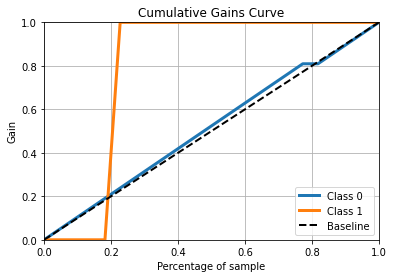

In [ ]:
eastern_clf_pred = eastern_clf.predict_proba(valid_X)
 
# Plot cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, eastern_clf_pred)
plt.show()

In [ ]:
# Run a linear regression
eastern_reg = LinearRegression()
eastern_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': eastern_reg.coef_[0], 'odds': np.e**eastern_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.123565  0.883765
A2_Score   0.090722  1.094965
A3_Score   0.173216  1.189122
A4_Score   0.033002  1.033553
A5_Score   0.077453  1.080532
A6_Score   0.399949  1.491748
A7_Score   0.154070  1.166572
A8_Score   0.104639  1.110309
A9_Score  -0.006105  0.993913
A10_Score  0.094293  1.098882


In [ ]:
# Check accuracy
regressionSummary(valid_Y, eastern_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0347
Root Mean Squared Error (RMSE) : 0.2007
     Mean Absolute Error (MAE) : 0.1218


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

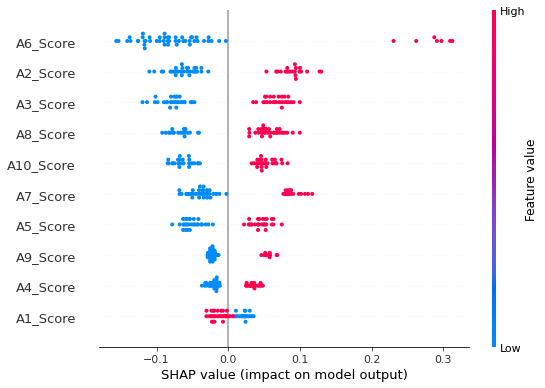

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(eastern_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Run a logistic Regression
eastern_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
eastern_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': eastern_log_reg.coef_[0], 'odds': np.e**eastern_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.688278  0.502441
A2_Score   0.333134  1.395334
A3_Score   0.104790  1.110477
A4_Score  -0.175119  0.839357
A5_Score   0.156537  1.169454
A6_Score   1.132651  3.103874
A7_Score   0.224857  1.252143
A8_Score  -0.039395  0.961371
A9_Score   0.091852  1.096203
A10_Score  0.040537  1.041370


In [ ]:
# Check accuracy
classificationSummary(valid_Y, eastern_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9545)

       Prediction
Actual  0  1
     0 21  0
     1  1  0


In [ ]:
# Create dataset with _Score variables and ID. Set ID as the index
eastern_scores = eastern_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
eastern_scores.set_index('ID', inplace=True)
eastern_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
15,1,1,0,1,1,0,0,1,0,1
16,1,0,0,0,0,0,1,1,1,1
22,0,0,0,1,0,0,1,1,1,1
23,0,0,0,0,0,0,0,1,0,1
27,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Check for frequent itemsets using apriori. 
questionsets = apriori(eastern_scores, min_support=.15, use_colnames=True) # Set min frequency to 15%.
questionsets.head()

,support,itemsets
0,0.574074,(A1_Score)
1,0.407407,(A2_Score)
2,0.481481,(A3_Score)
3,0.425926,(A4_Score)
4,0.481481,(A5_Score)


In [ ]:
# Check for relations between _Score variables using association rules.
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use confidence as metric and set threshold to 50%
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
89,"(A10_Score, A3_Score)","(A8_Score, A5_Score)",0.277778,0.314815,0.166667,0.600000,1.905882,0.079218,1.712963
85,"(A8_Score, A5_Score)","(A10_Score, A3_Score)",0.314815,0.277778,0.166667,0.529412,1.905882,0.079218,1.534722
77,"(A1_Score, A3_Score)","(A8_Score, A5_Score)",0.277778,0.314815,0.166667,0.600000,1.905882,0.079218,1.712963
78,"(A8_Score, A5_Score)","(A1_Score, A3_Score)",0.314815,0.277778,0.166667,0.529412,1.905882,0.079218,1.534722
84,"(A8_Score, A10_Score, A3_Score)",(A5_Score),0.185185,0.481481,0.166667,0.900000,1.869231,0.077503,5.185185


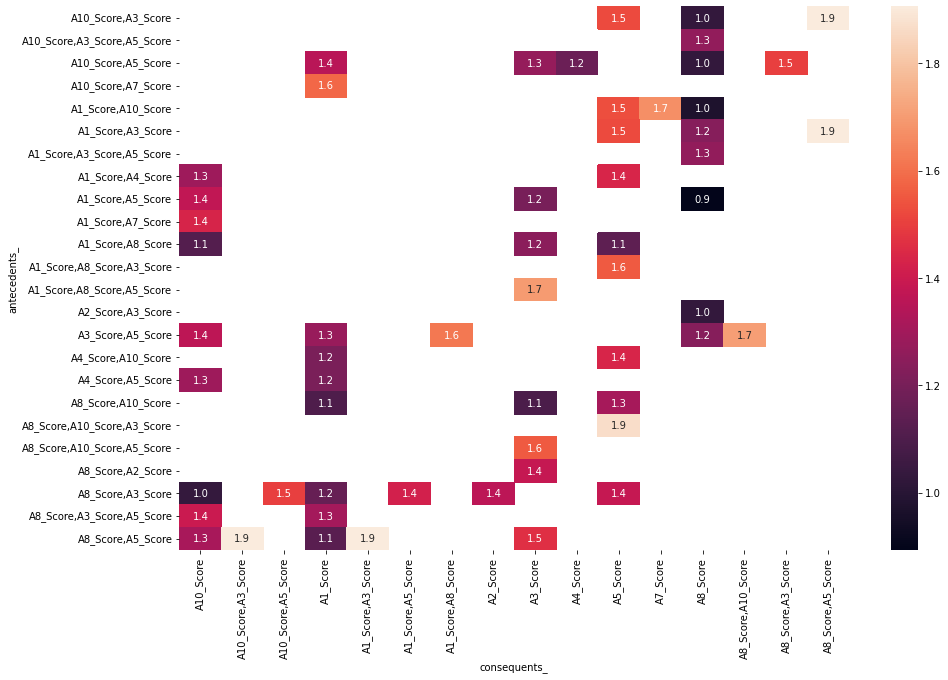

In [ ]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [ ]:
male_df['ethnicity'].value_counts() # Group 'Others' has the second most number of records. Will require further investigation if found significant

White             109
Asian              72
Others             63
Middle Eastern     54
Black              20
South Asian        16
Latino             12
Hispanic           11
Pasifika            6
Turkish             4
Name: ethnicity, dtype: int64

In [ ]:
# Create a dataset for others
others_df = male_df[(male_df['ethnicity']=='Others')]
others_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
5,5,1,1,1,1,1,0,1,1,1,...,36,m,Others,yes,no,United States,no,9,Self,YES
13,13,1,0,0,0,0,0,1,1,0,...,17,m,Others,no,no,Austria,no,4,Others,NO
19,19,0,0,0,0,0,0,1,1,0,...,34,m,Others,yes,no,United Arab Emirates,no,3,Others,NO
20,20,0,1,1,1,0,0,0,0,0,...,38,m,Others,no,no,United Arab Emirates,no,3,Others,NO
24,24,1,1,1,1,0,0,0,1,0,...,43,m,Others,no,no,Lebanon,no,5,Others,NO


In [ ]:
# Split the dataset with Class/ASD as the target variable, using only _Scores as perdictors.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= others_df[predictors]
y= others_df[outcome]
# Convert categorical varialbes to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [ ]:
# Create a maximal tree
othersFullTree = DecisionTreeClassifier(random_state=1)
othersFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, othersFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9231)

       Prediction
Actual  0  1
     0 22  0
     1  2  2


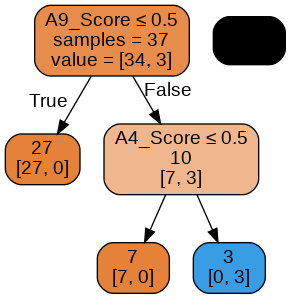

In [ ]:
# Plot the maximal tree
plotDecisionTree(othersFullTree, feature_names=train_X.columns)

In [ ]:
# Create decision tree parameters
param_grid = {
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [ ]:
# Run a grid search to find optimal parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 3 members, which is less than n_splits=5.


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [ ]:
# Check for best parameters
gridsearch.best_params_

{'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

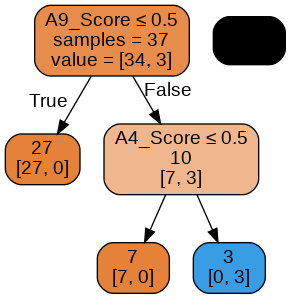

In [ ]:
# Plot the optimized tree
othersClassTree = DecisionTreeClassifier(max_depth=3, 
                                         min_impurity_decrease=0.02, 
                                         min_samples_split=0.07,
                                         random_state=1)
othersClassTree.fit(train_X, train_Y)
plotDecisionTree(othersClassTree, feature_names = train_X.columns)

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, othersClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9231)

       Prediction
Actual  0  1
     0 22  0
     1  2  2


In [ ]:
# Set random forest parameters 
param_grid = {
    'max_depth':[6, 7, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [ ]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [ ]:
# Check for best paramters
gridsearch.best_params_

{'max_depth': 6,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 100}

In [ ]:
# Run a random forest
othersForest = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=6, min_impurity_decrease=0.01, min_samples_split=0.05)
othersForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=6, min_impurity_decrease=0.01,
                       min_samples_split=0.05, random_state=1)

In [ ]:
# Check feature importance and standard deviation
importance = othersForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in othersForest.estimators_], axis=0)

othersForest_df = pd.DataFrame({'feature': train_X.columns,
                               'importance': importance,
                               'std': std})
print(othersForest_df.sort_values('importance', ascending=False))

     feature  importance       std
3   A4_Score    0.262752  0.263922
8   A9_Score    0.170225  0.208991
1   A2_Score    0.126066  0.182013
4   A5_Score    0.117362  0.196207
2   A3_Score    0.102436  0.159427
9  A10_Score    0.067173  0.157927
5   A6_Score    0.066175  0.156394
0   A1_Score    0.040072  0.099865
6   A7_Score    0.038114  0.100418
7   A8_Score    0.009626  0.042413


Text(0.5, 1.0, 'Visualizing Important Features')

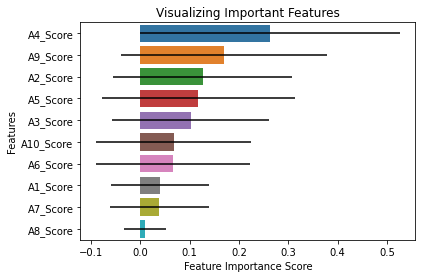

In [ ]:
# Plot feature importance
value_plot = othersForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [ ]:
# Check accuracy
classificationSummary(valid_Y, othersForest.predict(valid_X))

Confusion Matrix (Accuracy 0.8462)

       Prediction
Actual  0  1
     0 22  0
     1  4  0


In [ ]:
# Create optional hidden layer sizes for neural network
othersCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [ ]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=othersCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 3 members, which is less than n_splits=5.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [ ]:
# Check optimal hidden layer size
gridsearch.best_params_

{'hidden_layer_sizes': 2}

In [ ]:
# Run a neural network with 2 hidden layers
others_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=2, random_state=1)
others_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=2, random_state=1,
              solver='lbfgs')

In [ ]:
# Check model accuracy
classificationSummary(valid_Y, others_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8846)

       Prediction
Actual  0  1
     0 21  1
     1  2  2


<Figure size 720x720 with 0 Axes>

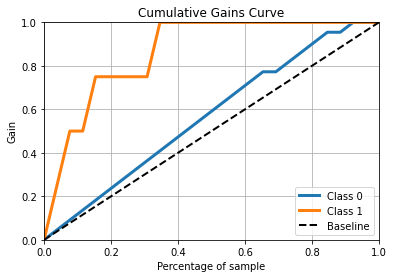

In [ ]:
others_clf_pred = others_clf.predict_proba(valid_X)

# Plot the cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, others_clf_pred)
plt.show()

In [ ]:
# Run a linear regression
others_reg = LinearRegression()
others_reg.fit(train_X, train_Y)

LinearRegression()

In [ ]:
# Check variable coefficients and ods ratio
print(pd.DataFrame({'coef': others_reg.coef_[0], 'odds': np.e**others_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.102228  1.107636
A2_Score   0.135460  1.145063
A3_Score   0.000333  1.000333
A4_Score   0.268859  1.308470
A5_Score   0.157363  1.170420
A6_Score   0.050429  1.051722
A7_Score   0.030417  1.030885
A8_Score  -0.010380  0.989673
A9_Score   0.116633  1.123707
A10_Score  0.058848  1.060615


In [ ]:
# Check accuracy
regressionSummary(valid_Y, others_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0193
Root Mean Squared Error (RMSE) : 0.2953
     Mean Absolute Error (MAE) : 0.2274


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

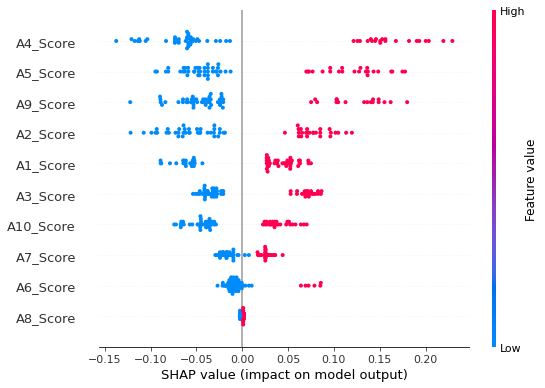

In [ ]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(others_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Run a logistic regression
others_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
others_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': others_log_reg.coef_[0], 'odds': np.e**others_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.104043  0.901186
A2_Score   0.206849  1.229796
A3_Score   0.391276  1.478867
A4_Score   0.711848  2.037753
A5_Score   0.443744  1.558531
A6_Score  -0.077395  0.925525
A7_Score  -0.058000  0.943650
A8_Score  -0.644209  0.525078
A9_Score   0.573496  1.774459
A10_Score -0.032099  0.968410


In [ ]:
# Check accuracy
classificationSummary(valid_Y, others_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8462)

       Prediction
Actual  0  1
     0 22  0
     1  4  0


In [ ]:
# Create a dataset using _Score variables and ID. Set ID as index.
others_scores = others_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
others_scores.set_index('ID', inplace=True)
others_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
5,1,1,1,1,1,0,1,1,1,1
13,1,0,0,0,0,0,1,1,0,1
19,0,0,0,0,0,0,1,1,0,1
20,0,1,1,1,0,0,0,0,0,0
24,1,1,1,1,0,0,0,1,0,0


In [ ]:
# Check for frequent itemsets using apriori
questionsets = apriori(others_scores, min_support=.15, use_colnames=True) # Set minimum support to 15%.
questionsets.head()

,support,itemsets
0,0.634921,(A1_Score)
1,0.412698,(A2_Score)
2,0.349206,(A3_Score)
3,0.333333,(A4_Score)
4,0.365079,(A5_Score)


In [ ]:
# Check for relations between _Scores using association rules
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use confidence as the metric with 50% minimum threshold.
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
69,"(A4_Score, A8_Score)",(A3_Score),0.222222,0.349206,0.158730,0.714286,2.045455,0.081129,2.277778
15,(A4_Score),(A3_Score),0.333333,0.349206,0.222222,0.666667,1.909091,0.105820,1.952381
38,"(A1_Score, A4_Score)",(A3_Score),0.238095,0.349206,0.158730,0.666667,1.909091,0.075586,1.952381
16,(A3_Score),(A4_Score),0.349206,0.333333,0.222222,0.636364,1.909091,0.105820,1.833333
39,"(A1_Score, A3_Score)",(A4_Score),0.253968,0.333333,0.158730,0.625000,1.875000,0.074074,1.777778


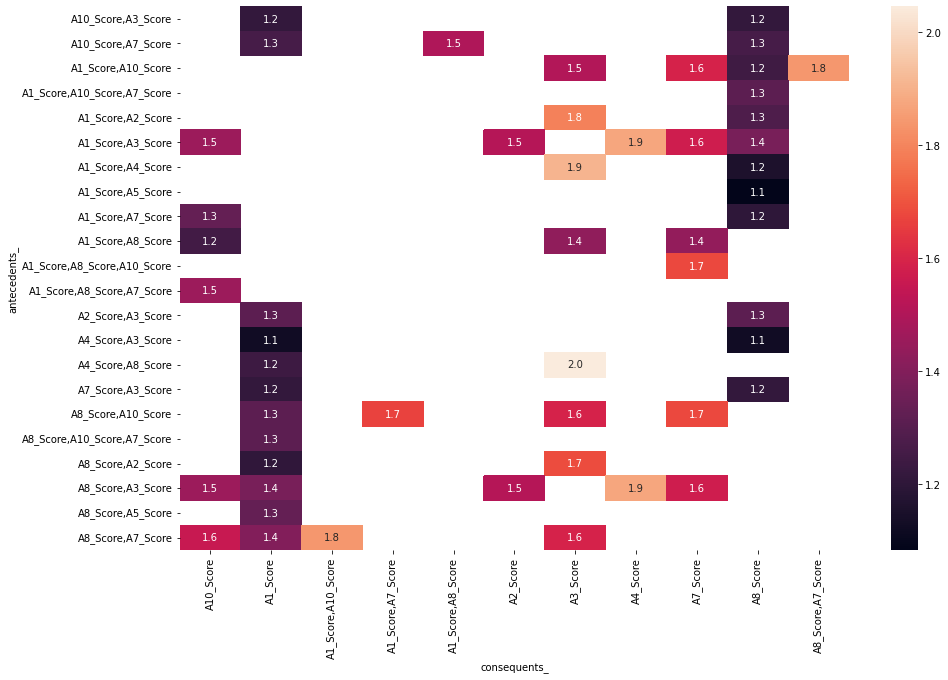

In [ ]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()